<a href="https://colab.research.google.com/github/dyhayy/Hactiv8_5/blob/main/Edit_Percobaan_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PREDIKSI HARGA SAHAM B**

## **1. Data Load**

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)
import warnings
warnings.filterwarnings('ignore')

import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from hyperopt import fmin, tpe, hp, Trials, space_eval
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

### Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU,Dropout,Dense
from tensorflow.keras.optimizers import RMSprop

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#data load
df = pd.read_csv('/content/drive/MyDrive/BBRI_2005-2025.csv')
df

,Date,Open,High,Low,Close,Volume
0,2005-05-06,119.439705,123.743842,119.439705,122.667801,143904485
1,2005-05-09,122.667809,124.819878,122.667809,124.819878,35151107
2,2005-05-10,124.819869,124.819869,121.591774,122.667801,52767911
3,2005-05-11,120.515747,120.515747,118.363678,120.515747,136363855
4,2005-05-12,120.515747,120.515747,118.363678,119.439713,127283198
...,...,...,...,...,...,...
4944,2025-05-27,4320.000000,4370.000000,4280.000000,4370.000000,180028000
4945,2025-05-28,4360.000000,4450.000000,4320.000000,4450.000000,466133500
4946,2025-06-02,4360.000000,4390.000000,4200.000000,4200.000000,389541100
4947,2025-06-03,4210.000000,4230.000000,4120.000000,4200.000000,277902300


## **2. Statistik Deskriptif**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4949 entries, 0 to 4948
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4949 non-null   object 
 1   Open    4949 non-null   float64
 2   High    4949 non-null   float64
 3   Low     4949 non-null   float64
 4   Close   4949 non-null   float64
 5   Volume  4949 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 232.1+ KB


In [ ]:
#mengecek missing value
df.isnull().values.any()

np.False_

In [ ]:
# Asumsi 'df' adalah dfFrame dengan kolom 'Open', 'High', 'Low', 'Close', 'Volume', dan indeks tanggal
fig = make_subplots(rows=2, cols=1,
                    subplot_titles=("Harga Saham (OHLC)", "Volume Perdagangan"))

# Menambahkan trace OHLC
fig.add_trace(go.Ohlc(x=df.index,
                      open=df['Open'],
                      high=df['High'],
                      low=df['Low'],
                      close=df['Close'],
                      name='Harga'), row=1, col=1)

# Menambahkan trace Volume
fig.add_trace(go.Scatter(x=df.index, y=df['Volume'], name='Volume'), row=2, col=1)

# Memperbarui layout untuk menyembunyikan range slider pada sumbu x
fig.update(layout_xaxis_rangeslider_visible=False)

# Memperbarui layout untuk menambahkan judul utama
fig.update_layout(title_text="Analisis Saham dan Volume Perdagangan")

# Menampilkan figure
fig.show()

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


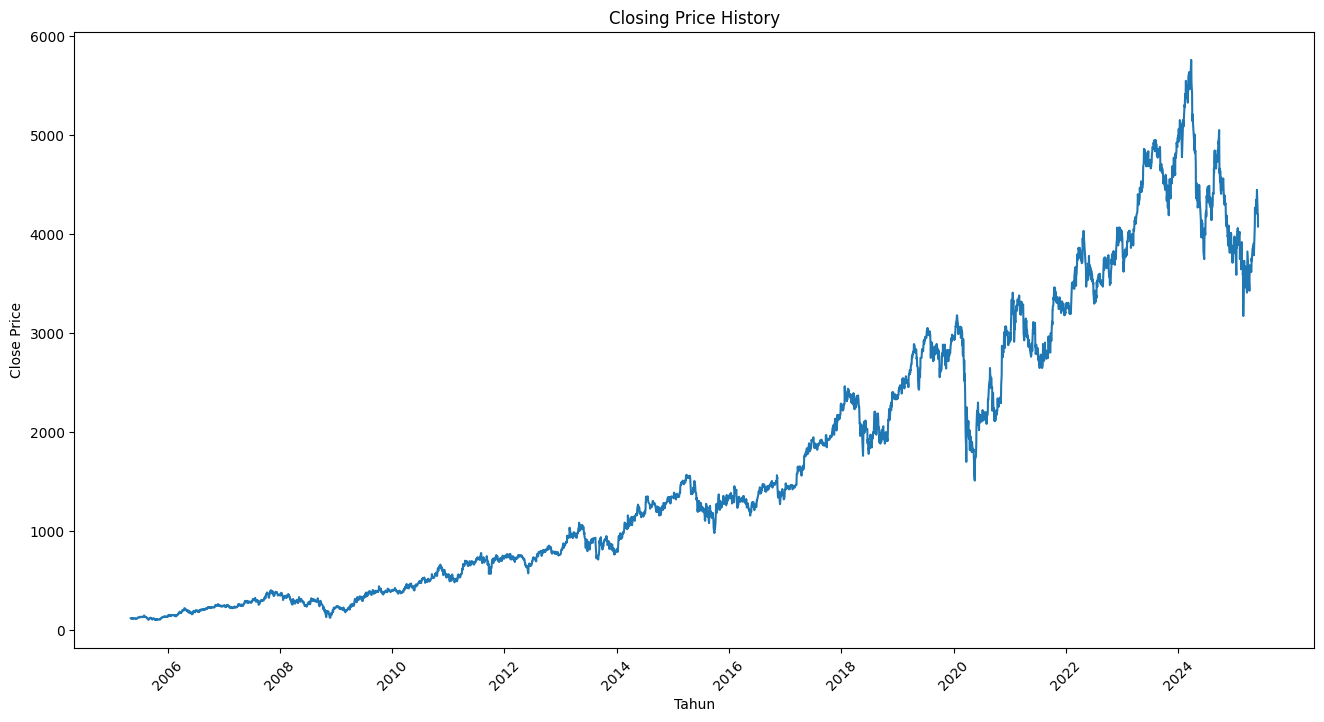

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(df['Close'])
plt.title("Closing Price History")
plt.xlabel("Tahun")
plt.ylabel("Close Price")

plt.xticks(
    pd.date_range(start=df.index.min(), end=df.index.max(), freq='2YS'),
    pd.date_range(start=df.index.min(), end=df.index.max(), freq='2YS').year,
    rotation=45
)

plt.show()


In [ ]:
#Melihat harga penutupan dan harga terendah
df.iloc[:, 2:-1].describe()

,Low,Close
count,4949.000000,4949.000000
mean,1677.184304,1696.317026
std,1396.964390,1410.126784
min,93.380960,105.907669
25%,437.239899,445.094543
50%,1267.065789,1281.868286
75%,2750.468601,2779.044922
max,5694.491883,5763.100098


## **3. Preprocessing Data**




### - Normalisasi Data

In [ ]:
#Memilih Harga Penutupan (Closing Price) dan mengkonvesi menjadi aray 2D
close_prices = df['Close'].values.reshape(-1, 1)

#Normalisasi df menggunakan Min-Max Scaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaler = scaler.fit_transform(close_prices)

In [ ]:
data_norm = pd.DataFrame(df_scaler)
data_norm

,0
0,0.002963
1,0.003343
2,0.002963
3,0.002582
4,0.002392
...,...
4944,0.753747
4945,0.767888
4946,0.723697
4947,0.723697


### - Slidding window dan Time Step

In [ ]:
def create_df(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps - 1):
        lag_values = data[i:(i + time_steps), 0]
        X.append(np.concatenate([lag_values, [data[i + time_steps, 0]]]))
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

In [ ]:
time_steps = 60
X, y = create_df(df_scaler, time_steps)

In [ ]:
# Calculate statistics
original_stats = pd.Series(df['Close'].values).describe()
scaled_stats = pd.Series(df_scaler.flatten()).describe()

# Melihat sebelum dan sesudah di scaled
print("Original Close Prices Statistics:")
print(original_stats)

print("\nScaled Close Prices Statistics:")
print(scaled_stats)

Original Close Prices Statistics:
count    4949.000000
mean     1696.317026
std      1410.126784
min       105.907669
25%       445.094543
50%      1281.868286
75%      2779.044922
max      5763.100098
dtype: float64

Scaled Close Prices Statistics:
count    4949.000000
mean        0.281131
std         0.249263
min         0.000000
25%         0.059957
50%         0.207870
75%         0.472520
max         1.000000
dtype: float64


### - Split Data

In [ ]:
# Membagi data menjadi 80% train, 10% validation, dan 10% test
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
test_size = len(X) - train_size - val_size

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

In [ ]:
# Shape of the datasets
print("Shapes of the datasets:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Shapes of the datasets:
X_train: (3910, 61), y_train: (3910,)
X_val: (488, 61), y_val: (488,)
X_test: (490, 61), y_test: (490,)


#### DATA TRAINING (80%)

In [ ]:
data_train =  pd.DataFrame(df_scaler[:train_size])

print(f"Data Train")
data_train

Data Train


,0
0,0.002963
1,0.003343
2,0.002963
3,0.002582
4,0.002392
...,...
3905,0.496712
3906,0.523840
3907,0.518907
3908,0.521373


#### DATA VALIDATION (10%)

In [ ]:
data_validation = pd.DataFrame(df_scaler[train_size:train_size + val_size])

print(f"Data Validation")
data_validation

Data Validation


,0
0,0.532471
1,0.531238
2,0.550968
3,0.554667
4,0.558366
...,...
483,0.661279
484,0.656891
485,0.648117
486,0.652504


#### DATA TESTING (10%)

In [ ]:
data_test = pd.DataFrame(df_scaler[train_size + val_size:])

print(f"Data Test")
data_test

Data Test


,0
0,0.655429
1,0.651042
2,0.665666
3,0.653967
4,0.675902
...,...
546,0.753747
547,0.767888
548,0.723697
549,0.723697


## **4. Hyperparameter Tuning**

In [ ]:
# Reshape data for LSTM and GRU models
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_val_lstm = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

X_train_gru = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_gru = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_val_gru = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

In [ ]:
# Set seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Define hyperparameter search space
space = {
    'units1': hp.quniform('units1', 16, 64, 1),
    'units2': hp.quniform('units2', 16, 64, 1),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
    'epochs': hp.quniform('epochs', 50, 150, 1),
    'batch_size': hp.choice('batch_size', [32, 64])
}

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

## **5. MODEL LSTM**


### - Mencari Kombinasi Hyperparameter Terbaik (Bayesian Optimization)

In [ ]:
def lstm_model(params, X_train, y_train, X_val, y_val):
    model = Sequential()
    model.add(LSTM(units=int(params['units1']), return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(params['dropout_rate']))
    model.add(LSTM(units=int(params['units2']), activation='tanh'))
    model.add(Dense(units=1))

    model.compile(optimizer=RMSprop(learning_rate=params['learning_rate']), loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=int(params['epochs']), batch_size=int(params['batch_size']),
                        validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_val)
    y_pred = scaler.inverse_transform(y_pred)
    y_val_orig = scaler.inverse_transform(y_val.reshape(-1, 1))
    mse = mean_squared_error(y_val_orig, y_pred)
    return {'loss': mse, 'status': 'ok', 'params': params}

# Set up the Trials object to keep track of the optimization process
trials_lstm = Trials()

# Use the fmin function for Bayesian optimization for LSTM
best_lstm = fmin(fn=lambda params: lstm_model(params, X_train_lstm, y_train, X_val_lstm, y_val),
                 space=space, algo=tpe.suggest, max_evals=40, trials=trials_lstm)


 1/16 ━━━━━━━━━━━━━━━━━━━━ 4s 317ms/step
 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 
 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

 1/16 ━━━━━━━━━━━━━━━━━━━━ 4s 320ms/step
 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

 1/16 ━━━━━━━━━━━━━━━━━━━━ 7s 478ms/step
 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step 
 6/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 1/16 ━━━━━━━━━━━━━━━━━━━━ 4s 325ms/step
 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 
 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

### - Hyperparameter Terbaik

In [ ]:
results_lstm = []
for trial in trials_lstm.trials:
    mse = trial['result']['loss']
    params = trial['result']['params']
    rmse = math.sqrt(mse)
    results_lstm.append({**params, 'mse': mse, 'rmse': rmse})

# Convert results to DataFrame
df_lstm = pd.DataFrame(results_lstm)

# Display the DataFrames
print("LSTM Hyperparameter Results:")
print(df_lstm)

# Get the best hyperparameters from the optimization results
best_params_lstm = space_eval(space, best_lstm)

# Display the best hyperparameters
print("\nBest Hyperparameters for LSTM:")
print(best_params_lstm)

LSTM Hyperparameter Results:
    batch_size  dropout_rate  epochs  learning_rate  units1  units2  \
0           32      0.256012    57.0       0.002558    27.0    55.0   
1           64      0.375291   128.0       0.001238    32.0    42.0   
2           64      0.295748   137.0       0.001488    30.0    62.0   
3           32      0.367671    65.0       0.000586    43.0    52.0   
4           64      0.242937    70.0       0.000371    41.0    48.0   
5           64      0.271346    66.0       0.000204    32.0    59.0   
6           32      0.384030   108.0       0.001046    36.0    29.0   
7           32      0.488387   105.0       0.002613    18.0    31.0   
8           32      0.429239    90.0       0.003432    43.0    46.0   
9           32      0.238616    82.0       0.000499    44.0    41.0   
10          64      0.421991   121.0       0.000988    59.0    36.0   
11          64      0.458730    68.0       0.000226    61.0    40.0   
12          64      0.283146   115.0       0.000

### - Modeling

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
import os

In [ ]:
finalmodel_lstm = Sequential([
    LSTM(units=int(best_params_lstm['units1']), return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(best_params_lstm['dropout_rate']),
    LSTM(units=int(best_params_lstm['units2'])),
    Dense(units=1)
])

finalmodel_lstm.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=best_params_lstm['learning_rate']),
                         loss='mean_squared_error')

In [ ]:
savemodel = '/content/drive/MyDrive/Colab Notebooks/Codingan Skripsi/MODEL_LSTM&GRU'

In [ ]:
LSTM_BestModel = os.path.join(savemodel, 'best_lstm_model.h5')

checkpoint_lstm = ModelCheckpoint(LSTM_BestModel,
                                  monitor='val_loss',
                                  save_best_only=True,
                                  mode='min',
                                  verbose=1)

# Train LSTM
print("\nTraining Final LSTM Model...")
history_lstm = finalmodel_lstm.fit(X_train_lstm, y_train,
                                    epochs=int(best_params_lstm['epochs']),
                                    batch_size=int(best_params_lstm['batch_size']),
                                    verbose=2,
                                    validation_data=(X_val_lstm, y_val),
                                    callbacks=[early_stopping, checkpoint_lstm])


Training Final LSTM Model...
Epoch 1/75

Epoch 1: val_loss improved from inf to 0.00136, saving model to /content/drive/MyDrive/Colab Notebooks/Codingan Skripsi/MODEL_LSTM&GRU/best_lstm_model.h5


123/123 - 11s - 93ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 2/75

Epoch 2: val_loss improved from 0.00136 to 0.00049, saving model to /content/drive/MyDrive/Colab Notebooks/Codingan Skripsi/MODEL_LSTM&GRU/best_lstm_model.h5


123/123 - 11s - 87ms/step - loss: 4.5745e-04 - val_loss: 4.9414e-04
Epoch 3/75

Epoch 3: val_loss did not improve from 0.00049
123/123 - 8s - 64ms/step - loss: 3.6797e-04 - val_loss: 0.0013
Epoch 4/75

Epoch 4: val_loss did not improve from 0.00049
123/123 - 7s - 60ms/step - loss: 3.2598e-04 - val_loss: 6.6614e-04
Epoch 5/75

Epoch 5: val_loss improved from 0.00049 to 0.00039, saving model to /content/drive/MyDrive/Colab Notebooks/Codingan Skripsi/MODEL_LSTM&GRU/best_lstm_model.h5


123/123 - 9s - 74ms/step - loss: 2.6193e-04 - val_loss: 3.8783e-04
Epoch 6/75

Epoch 6: val_loss improved from 0.00039 to 0.00030, saving model to /content/drive/MyDrive/Colab Notebooks/Codingan Skripsi/MODEL_LSTM&GRU/best_lstm_model.h5


123/123 - 7s - 56ms/step - loss: 2.7155e-04 - val_loss: 3.0388e-04
Epoch 7/75

Epoch 7: val_loss did not improve from 0.00030
123/123 - 8s - 69ms/step - loss: 2.5284e-04 - val_loss: 4.7746e-04
Epoch 8/75

Epoch 8: val_loss did not improve from 0.00030
123/123 - 7s - 53ms/step - loss: 2.3892e-04 - val_loss: 0.0013
Epoch 9/75

Epoch 9: val_loss improved from 0.00030 to 0.00028, saving model to /content/drive/MyDrive/Colab Notebooks/Codingan Skripsi/MODEL_LSTM&GRU/best_lstm_model.h5


123/123 - 9s - 74ms/step - loss: 2.3633e-04 - val_loss: 2.7611e-04
Epoch 10/75

Epoch 10: val_loss did not improve from 0.00028
123/123 - 8s - 67ms/step - loss: 2.1226e-04 - val_loss: 3.4918e-04
Epoch 11/75

Epoch 11: val_loss did not improve from 0.00028
123/123 - 10s - 80ms/step - loss: 2.0905e-04 - val_loss: 3.6938e-04
Epoch 12/75

Epoch 12: val_loss did not improve from 0.00028
123/123 - 8s - 68ms/step - loss: 1.9661e-04 - val_loss: 4.6396e-04
Epoch 13/75

Epoch 13: val_loss did not improve from 0.00028
123/123 - 9s - 74ms/step - loss: 1.9430e-04 - val_loss: 5.7020e-04
Epoch 14/75

Epoch 14: val_loss did not improve from 0.00028
123/123 - 10s - 79ms/step - loss: 1.9129e-04 - val_loss: 3.8234e-04
Epoch 15/75

Epoch 15: val_loss did not improve from 0.00028
123/123 - 8s - 68ms/step - loss: 1.8124e-04 - val_loss: 4.1268e-04
Epoch 16/75

Epoch 16: val_loss did not improve from 0.00028
123/123 - 7s - 53ms/step - loss: 1.7055e-04 - val_loss: 3.9894e-04
Epoch 17/75

Epoch 17: val_loss imp

123/123 - 11s - 92ms/step - loss: 1.7299e-04 - val_loss: 2.3606e-04
Epoch 18/75

Epoch 18: val_loss did not improve from 0.00024
123/123 - 8s - 68ms/step - loss: 1.6658e-04 - val_loss: 4.1979e-04
Epoch 19/75

Epoch 19: val_loss improved from 0.00024 to 0.00023, saving model to /content/drive/MyDrive/Colab Notebooks/Codingan Skripsi/MODEL_LSTM&GRU/best_lstm_model.h5


123/123 - 7s - 58ms/step - loss: 1.6660e-04 - val_loss: 2.2876e-04
Epoch 20/75

Epoch 20: val_loss did not improve from 0.00023
123/123 - 9s - 70ms/step - loss: 1.5286e-04 - val_loss: 2.3564e-04
Epoch 21/75

Epoch 21: val_loss did not improve from 0.00023
123/123 - 7s - 54ms/step - loss: 1.4599e-04 - val_loss: 3.3064e-04
Epoch 22/75

Epoch 22: val_loss improved from 0.00023 to 0.00021, saving model to /content/drive/MyDrive/Colab Notebooks/Codingan Skripsi/MODEL_LSTM&GRU/best_lstm_model.h5


123/123 - 9s - 73ms/step - loss: 1.5680e-04 - val_loss: 2.1113e-04
Epoch 23/75

Epoch 23: val_loss did not improve from 0.00021
123/123 - 7s - 54ms/step - loss: 1.4772e-04 - val_loss: 2.2526e-04
Epoch 24/75

Epoch 24: val_loss did not improve from 0.00021
123/123 - 8s - 68ms/step - loss: 1.4064e-04 - val_loss: 9.5698e-04
Epoch 25/75

Epoch 25: val_loss did not improve from 0.00021
123/123 - 7s - 58ms/step - loss: 1.5501e-04 - val_loss: 4.4894e-04
Epoch 26/75

Epoch 26: val_loss improved from 0.00021 to 0.00019, saving model to /content/drive/MyDrive/Colab Notebooks/Codingan Skripsi/MODEL_LSTM&GRU/best_lstm_model.h5


123/123 - 10s - 84ms/step - loss: 1.4430e-04 - val_loss: 1.9361e-04
Epoch 27/75

Epoch 27: val_loss did not improve from 0.00019
123/123 - 8s - 68ms/step - loss: 1.3390e-04 - val_loss: 3.8890e-04
Epoch 28/75

Epoch 28: val_loss did not improve from 0.00019
123/123 - 7s - 54ms/step - loss: 1.3777e-04 - val_loss: 4.3530e-04
Epoch 29/75

Epoch 29: val_loss did not improve from 0.00019
123/123 - 10s - 83ms/step - loss: 1.3337e-04 - val_loss: 2.0450e-04
Epoch 30/75

Epoch 30: val_loss did not improve from 0.00019
123/123 - 8s - 67ms/step - loss: 1.4106e-04 - val_loss: 2.0077e-04
Epoch 31/75

Epoch 31: val_loss did not improve from 0.00019
123/123 - 7s - 53ms/step - loss: 1.3606e-04 - val_loss: 3.5915e-04
Epoch 32/75

Epoch 32: val_loss improved from 0.00019 to 0.00019, saving model to /content/drive/MyDrive/Colab Notebooks/Codingan Skripsi/MODEL_LSTM&GRU/best_lstm_model.h5


123/123 - 12s - 96ms/step - loss: 1.2933e-04 - val_loss: 1.9321e-04
Epoch 33/75

Epoch 33: val_loss improved from 0.00019 to 0.00019, saving model to /content/drive/MyDrive/Colab Notebooks/Codingan Skripsi/MODEL_LSTM&GRU/best_lstm_model.h5


123/123 - 8s - 66ms/step - loss: 1.2835e-04 - val_loss: 1.8570e-04
Epoch 34/75

Epoch 34: val_loss did not improve from 0.00019
123/123 - 9s - 71ms/step - loss: 1.2999e-04 - val_loss: 1.9053e-04
Epoch 35/75

Epoch 35: val_loss did not improve from 0.00019
123/123 - 8s - 68ms/step - loss: 1.2097e-04 - val_loss: 2.3205e-04
Epoch 36/75

Epoch 36: val_loss did not improve from 0.00019
123/123 - 7s - 54ms/step - loss: 1.3231e-04 - val_loss: 4.9293e-04
Epoch 37/75

Epoch 37: val_loss improved from 0.00019 to 0.00017, saving model to /content/drive/MyDrive/Colab Notebooks/Codingan Skripsi/MODEL_LSTM&GRU/best_lstm_model.h5


123/123 - 9s - 72ms/step - loss: 1.2339e-04 - val_loss: 1.6655e-04
Epoch 38/75

Epoch 38: val_loss did not improve from 0.00017
123/123 - 7s - 57ms/step - loss: 1.1756e-04 - val_loss: 6.3143e-04
Epoch 39/75

Epoch 39: val_loss did not improve from 0.00017
123/123 - 8s - 64ms/step - loss: 1.2474e-04 - val_loss: 1.8197e-04
Epoch 40/75

Epoch 40: val_loss did not improve from 0.00017
123/123 - 11s - 87ms/step - loss: 1.1506e-04 - val_loss: 2.8160e-04
Epoch 41/75

Epoch 41: val_loss improved from 0.00017 to 0.00016, saving model to /content/drive/MyDrive/Colab Notebooks/Codingan Skripsi/MODEL_LSTM&GRU/best_lstm_model.h5


123/123 - 9s - 73ms/step - loss: 1.1697e-04 - val_loss: 1.5862e-04
Epoch 42/75

Epoch 42: val_loss did not improve from 0.00016
123/123 - 10s - 80ms/step - loss: 1.1406e-04 - val_loss: 5.3513e-04
Epoch 43/75

Epoch 43: val_loss improved from 0.00016 to 0.00016, saving model to /content/drive/MyDrive/Colab Notebooks/Codingan Skripsi/MODEL_LSTM&GRU/best_lstm_model.h5


123/123 - 12s - 98ms/step - loss: 1.1578e-04 - val_loss: 1.5742e-04
Epoch 44/75

Epoch 44: val_loss did not improve from 0.00016
123/123 - 10s - 81ms/step - loss: 1.1878e-04 - val_loss: 2.1557e-04
Epoch 45/75

Epoch 45: val_loss did not improve from 0.00016
123/123 - 9s - 69ms/step - loss: 1.1627e-04 - val_loss: 2.2689e-04
Epoch 46/75

Epoch 46: val_loss did not improve from 0.00016
123/123 - 8s - 68ms/step - loss: 1.1628e-04 - val_loss: 3.2298e-04
Epoch 47/75

Epoch 47: val_loss did not improve from 0.00016
123/123 - 10s - 79ms/step - loss: 1.1013e-04 - val_loss: 2.5392e-04
Epoch 48/75

Epoch 48: val_loss did not improve from 0.00016
123/123 - 9s - 74ms/step - loss: 1.1062e-04 - val_loss: 2.6224e-04
Epoch 49/75

Epoch 49: val_loss did not improve from 0.00016
123/123 - 8s - 68ms/step - loss: 1.1001e-04 - val_loss: 1.9551e-04
Epoch 50/75

Epoch 50: val_loss did not improve from 0.00016
123/123 - 7s - 53ms/step - loss: 1.0962e-04 - val_loss: 2.6450e-04
Epoch 51/75

Epoch 51: val_loss di

In [ ]:
print("Best LSTM Model")
final_model_lstm = load_model(LSTM_BestModel)
final_model_lstm.summary()

Best LSTM Model


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_80 (LSTM)                  │ (None, 61, 54)         │        12,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 61, 54)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_81 (LSTM)                  │ (None, 62)             │        29,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,177 (160.85 KB)

 Trainable params: 41,175 (160.84 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

## **6. GRU**

### - Mencari Kombinasi Hyperparameter Terbaik (Bayesian Optimization)

In [ ]:
def gru_model(params, X_train, y_train, X_val, y_val):
    model = Sequential()
    model.add(GRU(units=int(params['units1']), return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(params['dropout_rate']))
    model.add(GRU(units=int(params['units2']), activation='tanh'))
    model.add(Dense(units=1))

    model.compile(optimizer=RMSprop(learning_rate=params['learning_rate']), loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=int(params['epochs']), batch_size=int(params['batch_size']),
                        validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_val)
    y_pred = scaler.inverse_transform(y_pred)
    y_val_orig = scaler.inverse_transform(y_val.reshape(-1, 1))
    mse = mean_squared_error(y_val_orig, y_pred)
    return {'loss': mse, 'status': 'ok', 'params': params}

# Set up the Trials object to keep track of the optimization process
trials_gru = Trials()

# Use the fmin function for Bayesian optimization for GRU
best_gru = fmin(fn=lambda params: gru_model(params, X_train_gru, y_train, X_val_gru, y_val),
                 space=space, algo=tpe.suggest, max_evals=40, trials=trials_gru)

 1/16 ━━━━━━━━━━━━━━━━━━━━ 5s 357ms/step
 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

 1/16 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step
 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

 1/16 ━━━━━━━━━━━━━━━━━━━━ 7s 492ms/step
 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 
 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

 1/16 ━━━━━━━━━━━━━━━━━━━━ 9s 605ms/step
 4/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 
 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

### - Hyperparameter Terbaik

In [ ]:
# Extract results for GRU
results_gru = []
for trial in trials_gru.trials:
    mse = trial['result']['loss']
    params = trial['result']['params']
    rmse = math.sqrt(mse)
    results_gru.append({**params, 'mse': mse, 'rmse': rmse})

# Convert results to DataFrame
df_gru = pd.DataFrame(results_gru)

# Display the DataFrames
print("GRU Hyperparameter Results:")
print(df_gru)

# Get the best hyperparameters from the optimization results
best_params_gru = space_eval(space, best_gru)

# Display the best hyperparameters
print("\nBest Hyperparameters for GRU:")
print(best_params_gru)

GRU Hyperparameter Results:
    batch_size  dropout_rate  epochs  learning_rate  units1  units2  \
0           64      0.276695   121.0       0.000179    53.0    24.0   
1           32      0.453289   111.0       0.000185    23.0    60.0   
2           32      0.382640   130.0       0.002807    40.0    19.0   
3           32      0.403996    64.0       0.005639    54.0    62.0   
4           64      0.487343   100.0       0.000275    34.0    31.0   
5           64      0.421507    87.0       0.001336    50.0    32.0   
6           64      0.246872   115.0       0.000354    45.0    39.0   
7           64      0.204561   100.0       0.000287    49.0    18.0   
8           64      0.376398   135.0       0.001003    21.0    51.0   
9           64      0.342469    67.0       0.002812    17.0    51.0   
10          64      0.216677   139.0       0.000258    49.0    56.0   
11          64      0.307017    60.0       0.000142    27.0    54.0   
12          64      0.322344    73.0       0.0017

### - Modeling

In [ ]:
finalmodel_gru = Sequential([
    GRU(units=int(best_params_gru['units1']), return_sequences=True, input_shape=(X_train_gru.shape[1], 1)),
    Dropout(best_params_gru['dropout_rate']),
    GRU(units=int(best_params_gru['units2'])),
    Dense(units=1)
])

finalmodel_gru.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=best_params_gru['learning_rate']),
                        loss='mean_squared_error')

In [ ]:
GRU_BestModel = os.path.join(savemodel, 'best_gru_model.h5')

checkpoint_gru = ModelCheckpoint(GRU_BestModel,
                                 monitor='val_loss',
                                 save_best_only=True,
                                 mode='min',
                                 verbose=1)

# Train GRU
print("\nTraining Final GRU Model...")
history_gru = finalmodel_gru.fit(X_train_gru, y_train,
                                  epochs=int(best_params_gru['epochs']),
                                  batch_size=int(best_params_gru['batch_size']),
                                  verbose=2,
                                  validation_data=(X_val_gru, y_val),
                                  callbacks=[early_stopping, checkpoint_gru])



Training Final GRU Model...
Epoch 1/59

Epoch 1: val_loss improved from inf to 0.00052, saving model to /content/drive/MyDrive/Colab Notebooks/Codingan Skripsi/MODEL_LSTM&GRU/best_gru_model.h5


123/123 - 14s - 114ms/step - loss: 0.0032 - val_loss: 5.2363e-04
Epoch 2/59

Epoch 2: val_loss improved from 0.00052 to 0.00016, saving model to /content/drive/MyDrive/Colab Notebooks/Codingan Skripsi/MODEL_LSTM&GRU/best_gru_model.h5


123/123 - 10s - 83ms/step - loss: 0.0013 - val_loss: 1.5576e-04
Epoch 3/59

Epoch 3: val_loss did not improve from 0.00016
123/123 - 8s - 67ms/step - loss: 9.6129e-04 - val_loss: 8.3728e-04
Epoch 4/59

Epoch 4: val_loss did not improve from 0.00016
123/123 - 10s - 84ms/step - loss: 7.7602e-04 - val_loss: 5.8235e-04
Epoch 5/59

Epoch 5: val_loss improved from 0.00016 to 0.00008, saving model to /content/drive/MyDrive/Colab Notebooks/Codingan Skripsi/MODEL_LSTM&GRU/best_gru_model.h5


123/123 - 11s - 86ms/step - loss: 6.5531e-04 - val_loss: 7.7711e-05
Epoch 6/59

Epoch 6: val_loss did not improve from 0.00008
123/123 - 8s - 68ms/step - loss: 5.5883e-04 - val_loss: 0.0013
Epoch 7/59

Epoch 7: val_loss did not improve from 0.00008
123/123 - 10s - 82ms/step - loss: 5.0812e-04 - val_loss: 8.3236e-05
Epoch 8/59

Epoch 8: val_loss did not improve from 0.00008
123/123 - 10s - 82ms/step - loss: 4.7371e-04 - val_loss: 4.5585e-04
Epoch 9/59

Epoch 9: val_loss did not improve from 0.00008
123/123 - 8s - 68ms/step - loss: 4.1466e-04 - val_loss: 1.0113e-04
Epoch 10/59

Epoch 10: val_loss did not improve from 0.00008
123/123 - 10s - 82ms/step - loss: 4.2308e-04 - val_loss: 1.8096e-04
Epoch 11/59

Epoch 11: val_loss did not improve from 0.00008
123/123 - 10s - 82ms/step - loss: 3.7375e-04 - val_loss: 1.1543e-04
Epoch 12/59

Epoch 12: val_loss did not improve from 0.00008
123/123 - 17s - 135ms/step - loss: 3.4508e-04 - val_loss: 0.0012
Epoch 13/59

Epoch 13: val_loss did not improv

In [ ]:
print("Best GRU Model")
final_model_gru = load_model(GRU_BestModel)
final_model_gru.summary()

Best GRU Model


Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_80 (GRU)                    │ (None, 61, 54)         │         9,234 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 61, 54)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_81 (GRU)                    │ (None, 36)             │         9,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 1)              │            37 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,209 (75.04 KB)

 Trainable params: 19,207 (75.03 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

## **7. Evaluasi Model**

In [ ]:
import numpy as np
import pandas as pd
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [ ]:
y_pred_lstm = final_model_lstm.predict(X_test_lstm)
y_pred_gru= final_model_gru.predict(X_test_gru)
y_test_scaled = y_test.reshape(-1, 1)

print("\n" + "="*60)
print("PERBANDINGAN DATA AKTUAL,PREDICT LSTM, PREDICT GRU (0-1)")
print("="*60)

# Membuat DataFrame manual untuk view scaled
df_scaled_view = pd.DataFrame({
    'Actual (Scaled)': y_test_scaled.flatten(),
    'LSTM (Scaled)': y_pred_lstm.flatten(),
    'GRU (Scaled)': y_pred_gru.flatten()
})

df_scaled_view

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

PERBANDINGAN DATA AKTUAL,PREDICT LSTM, PREDICT GRU (0-1)


,Actual (Scaled),LSTM (Scaled),GRU (Scaled)
0,0.783206,0.760280,0.765649
1,0.764021,0.761892,0.764834
2,0.767858,0.762724,0.763843
3,0.771695,0.763402,0.764030
4,0.771695,0.763892,0.764459
...,...,...,...
485,0.744909,0.730702,0.737500
486,0.753747,0.735559,0.741384
487,0.767888,0.741113,0.747937
488,0.723697,0.741774,0.742281


In [ ]:
df_scaled_view.describe()

,Actual (Scaled),LSTM (Scaled),GRU (Scaled)
count,490.000000,490.000000,490.000000
mean,0.771306,0.762895,0.764075
std,0.089115,0.082141,0.081154
min,0.542641,0.597254,0.590713
25%,0.699979,0.694374,0.696935
50%,0.776192,0.767052,0.768952
75%,0.833086,0.817427,0.818957
max,1.000000,0.952598,0.957285


### - Denormalisasi Data

In [ ]:
# Mengembalikan ke harga asli
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)
y_pred_gru_inv = scaler.inverse_transform(y_pred_gru)
y_test_inv = scaler.inverse_transform(y_test_scaled)

In [ ]:
actual_values = pd.DataFrame(y_test_inv, columns=['Actual'])
lstm_predictions = pd.DataFrame(y_pred_lstm_inv, columns=['LSTM Prediction'])
gru_predictions = pd.DataFrame(y_pred_gru_inv, columns=['GRU Prediction'])

# Menggabungkan menjadi satu DataFrame
results_df = pd.concat([actual_values, lstm_predictions, gru_predictions], axis=1)

# Mengatur Index agar sesuai tanggal
results_df.index = df.index[time_steps + train_size + val_size:time_steps + train_size + val_size + test_size]

# Menampilkan DataFrame Hasil Akhir
results_df

,Actual,LSTM Prediction,GRU Prediction
Date,,,
2023-05-05,4536.653320,4406.959473,4437.331543
2023-05-08,4428.121094,4416.077148,4432.720215
2023-05-09,4449.827148,4420.781738,4427.114258
2023-05-10,4471.534180,4424.620605,4428.170410
2023-05-11,4471.534180,4427.388672,4430.600586
...,...,...,...
2025-05-26,4320.000000,4239.630859,4278.087402
2025-05-27,4370.000000,4267.104980,4300.059570
2025-05-28,4450.000000,4298.524902,4337.129883


### - Evaluasi Model (RMSE, MAPE)

In [ ]:
results_df.describe()

,Actual,LSTM Prediction,GRU Prediction
count,490.000000,490.000000,490.000000
mean,4469.331363,4421.749512,4428.427734
std,504.139324,464.686279,459.103699
min,3175.730469,3484.687500,3447.684814
25%,4065.824524,4034.114502,4048.603821
50%,4496.973389,4445.266602,4456.016846
75%,4818.837402,4730.251709,4738.905151
max,5763.100098,5494.938477,5521.452637


In [ ]:
print("\n" + "="*30)
print("EVALUASI PERFORMANCE MODEL")
print("="*30)

print("Performance Metrics for LSTM:")
print(f"Root Mean Squared Error (RMSE) : {rmse_lstm:.4f}")
print(f"Mean Absolute Percentage Error (MAPE) : {mape_lstm:.2f}%")
print("-" * 30)

print("Performance Metrics for GRU:")
print(f"Root Mean Squared Error (RMSE) : {rmse_gru:.4f}")
print(f"Mean Absolute Percentage Error (MAPE) : {mape_gru:.2f}%")


EVALUASI PERFORMANCE MODEL
Performance Metrics for LSTM:
Root Mean Squared Error (RMSE) : 118.9020
Mean Absolute Percentage Error (MAPE) : 2.13%
------------------------------
Performance Metrics for GRU:
Root Mean Squared Error (RMSE) : 92.2955
Mean Absolute Percentage Error (MAPE) : 1.64%


In [ ]:
fig = go.Figure()

# Plot Data Asli (Actual)
fig.add_trace(go.Scatter(x=results_df.index, y=results_df['Actual'],
                         mode='lines', name="Actual Stock Prices", line=dict(color='blue')))

# Plot Prediksi LSTM
fig.add_trace(go.Scatter(x=results_df.index,y=results_df['LSTM Prediction'],
                         mode='lines',name=f"LSTM Prediction (MAPE: {mape_lstm:.2f}%)",line=dict(color='red')))

# Plot Prediksi GRU
fig.add_trace(go.Scatter(x=results_df.index,y=results_df['GRU Prediction'], mode='lines',
                         name=f"GRU Prediction (MAPE: {mape_gru:.2f}%)",line=dict(color='orange')))

fig.update_layout(
    title="Stock Price Prediction (Actual vs LSTM vs GRU)",
    xaxis_title="Periode",
    yaxis_title="Stock Price (IDR)",
    template='plotly_white',
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1), width=1050,autosize=False
)

fig.show()

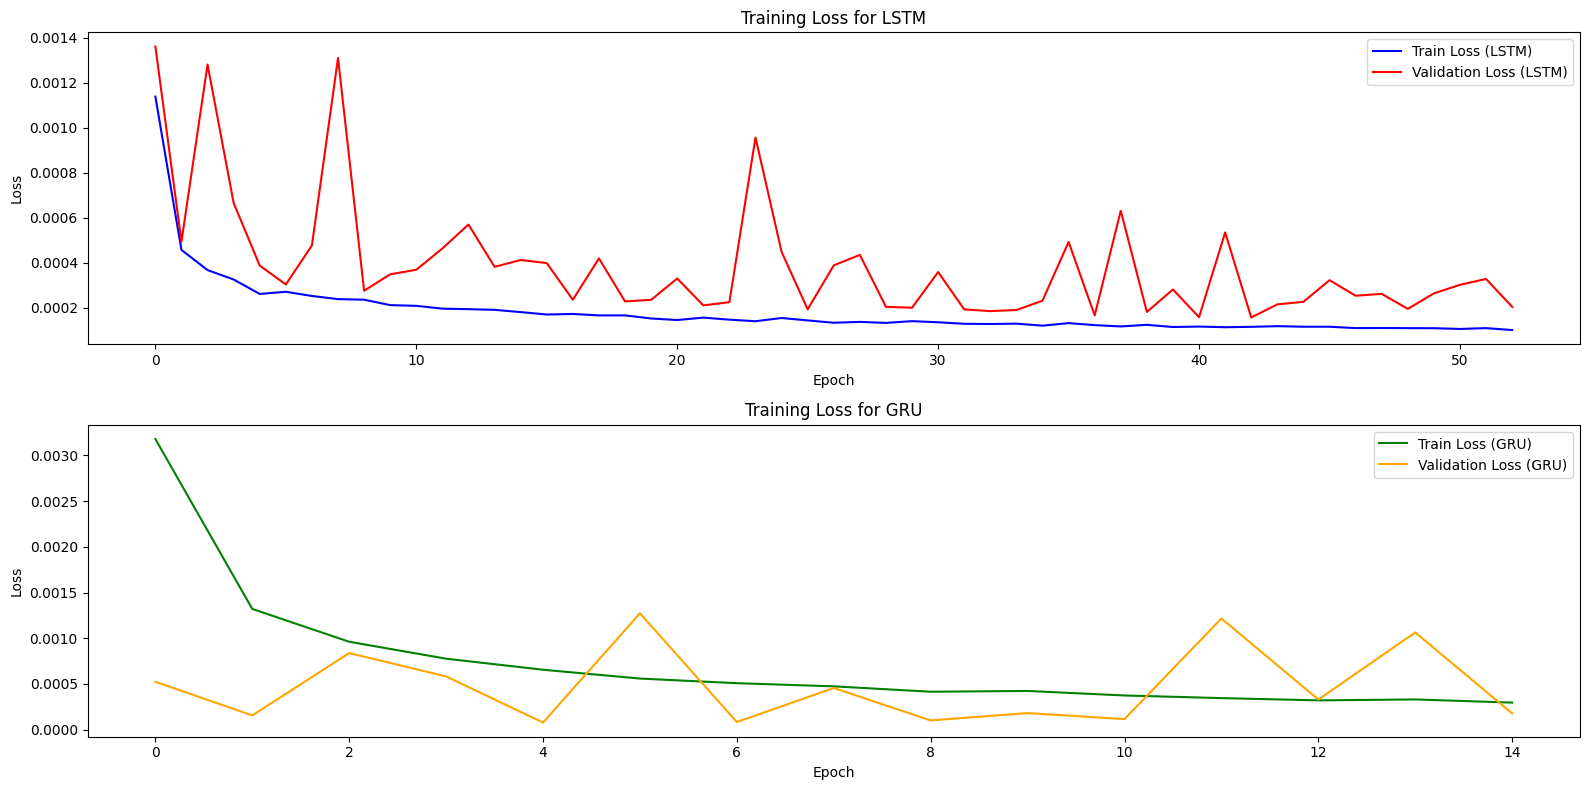

In [ ]:
# Plot training history using Matplotlib
plt.figure(figsize=(16, 8))

# Plot training loss for LSTM
plt.subplot(2, 1, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss (LSTM)', color='blue')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss (LSTM)', color='red')
plt.title('Training Loss for LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training loss for GRU
plt.subplot(2, 1, 2)
plt.plot(history_gru.history['loss'], label='Train Loss (GRU)', color='green')
plt.plot(history_gru.history['val_loss'], label='Validation Loss (GRU)', color='orange')
plt.title('Training Loss for GRU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

## **8. PREDIKSI SEBULAN KEDEPAN**

### - LSTM Prediction

In [ ]:
# Function to make future predictions using LSTM model
def lstm_predict_future(model, data, n_steps, n_days):
    predictions_lstm = []
    current_input = data[-n_steps:].reshape((1, n_steps, 1))

    for _ in range(n_days):
        next_prediction = model.predict(current_input)
        predictions_lstm.append(next_prediction[0, 0])
        current_input = np.append(current_input[:, 1:, :], next_prediction.reshape((1, 1, 1)), axis=1)

    return np.array(predictions_lstm)

# Assuming the final LSTM model and scaler are already defined and trained
n_days = 30  # Number of days to predict
lstm_predict = lstm_predict_future(final_model_lstm, df_scaler, time_steps , n_days)

# Inverse transform the predictions to get actual stock prices
lstm_predictions_actual = scaler.inverse_transform(lstm_predict.reshape(-1, 1))

# Creating a DataFrame for the future predictions with numbering
lstm_predictions_df = pd.DataFrame({'LSTM Prediction': lstm_predictions_actual.flatten()},
                                     index=np.arange(1, len(lstm_predictions_actual) + 1))

# Display the table
lstm_predictions_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━

,LSTM Prediction
1,4260.937500
2,4241.964844
3,4228.237793
4,4217.374512
5,4208.082520
6,4199.670898
7,4191.779785
8,4184.219238
9,4176.893555
10,4169.749512


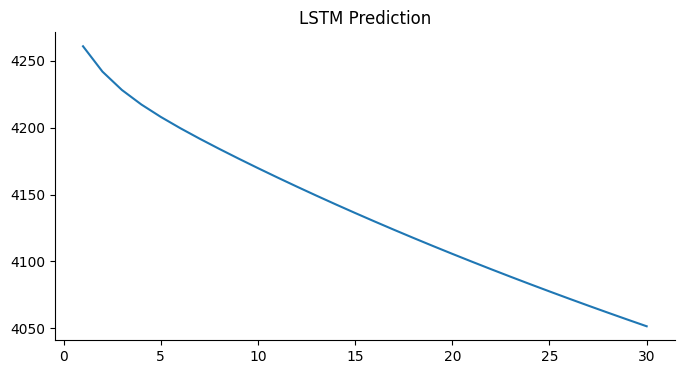

In [ ]:
from matplotlib import pyplot as plt
lstm_predictions_df['LSTM Prediction'].plot(kind='line', figsize=(8, 4), title='LSTM Prediction')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
else:
    df.index = pd.to_datetime(df.index)

df_2025 = df.loc['2025']
df_scaler_2025 = df_scaler[-len(df_2025):]

actual_2025 = scaler.inverse_transform(df_scaler_2025)

In [ ]:
n_days = 30
last_date = df_2025.index[-1]

future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=n_days,
    freq='B'
)


In [ ]:
fig = go.Figure()

# Actual price (2025)
fig.add_trace(go.Scatter(
    x=df_2025.index,
    y=actual_2025.flatten(),
    mode='lines',
    name='Actual Price (2025)',
    line=dict(color='blue')
))

# LSTM Prediction
fig.add_trace(go.Scatter(
    x=future_dates,
    y=lstm_predictions_actual.flatten(),
    mode='lines',
    name='LSTM Prediction (Next 30 Days)',
    line=dict(color='coral', dash='dot')
))

fig.update_layout(
    title='BBRI Stock Price Prediction (LSTM)',
    xaxis_title='Tanggal',
    yaxis_title='Harga Saham',
    template='plotly_white',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='center',
        x=0.5 ),
    width=1050,
    height=550,
)

fig.show()

### - GRU Prediction

In [ ]:
# Function to make future predictions using GRU model
def gru_predict_future(model, data, n_steps, n_days):
    predictions_gru = []
    current_input = data[-n_steps:].reshape((1, n_steps, 1))

    for _ in range(n_days):
        next_prediction = model.predict(current_input)
        predictions_gru.append(next_prediction[0, 0])
        current_input = np.append(current_input[:, 1:, :], next_prediction.reshape((1, 1, 1)), axis=1)

    return np.array(predictions_gru)

# Assuming the final GRU model and scaler are already defined and trained
n_days = 30  # Number of days to predict
gru_predict = gru_predict_future(final_model_gru, df_scaler, time_steps , n_days)

# Inverse transform the predictions to get actual stock prices
gru_predictions_actual = scaler.inverse_transform(gru_predict.reshape(-1, 1))

# Creating a DataFrame for the future predictions with numbering
gru_predictions_df = pd.DataFrame({'GRU Prediction': gru_predictions_actual.flatten()},
                                     index=np.arange(1, len(gru_predictions_actual) + 1))

# Display the table
gru_predictions_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━

,GRU Prediction
1,4201.934082
2,4181.690430
3,4172.415039
4,4166.099609
5,4160.669434
6,4155.573242
7,4150.659668
8,4145.878418
9,4141.212402
10,4136.655273


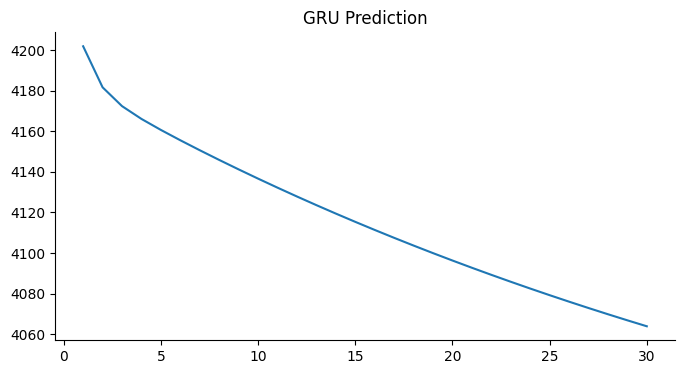

In [ ]:
from matplotlib import pyplot as plt
gru_predictions_df['GRU Prediction'].plot(kind='line', figsize=(8, 4), title='GRU Prediction')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
fig = go.Figure()

# Actual price (2025)
fig.add_trace(go.Scatter(
    x=df_2025.index,
    y=actual_2025.flatten(),
    mode='lines',
    name='Actual Price (2025)',
    line=dict(color='blue')
))

# GRU Prediction
fig.add_trace(go.Scatter(
    x=future_dates,
    y=gru_predictions_actual.flatten(),
    mode='lines',
    name='GRU Prediction (Next 30 Days)',
    line=dict(color='coral', dash='dot')
))

fig.update_layout(
    title='BBRI Stock Price Prediction (GRU)',
    xaxis_title='Tanggal',
    yaxis_title='Harga Saham',
    template='plotly_white',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='center',
        x=0.5 ),
    width=1050,
    height=550,
)


fig.show()


# SAVE DATA

In [ ]:
df_scaled_view.to_csv('hasil_prediksi_sebelum denormalisasi.csv')

# 2. Trigger download ke browser laptop kamu
files.download('hasil_prediksi_sebelum denormalisasi.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
import os

# 1. Simpan CSV dulu (seperti kodinganmu)
data_test.to_csv('data_test.csv', index=False)
data_validation.to_csv('data_validation.csv', index=False)
data_train.to_csv('data_train.csv', index=False)
data_norm.to_csv('data_normalisasi.csv', index=False)

# 2. Kompres jadi ZIP menggunakan perintah terminal Linux (tanda seru !)
# Syntax: !zip -r <nama_zip_output> <file1> <file2> ...
!zip -r semua_data.zip data_test.csv data_validation.csv data_train.csv data_normalisasi.csv

# 3. Download file ZIP-nya
files.download('semua_data.zip')

updating: data_test.csv (deflated 72%)
updating: data_validation.csv (deflated 73%)
updating: data_train.csv (deflated 77%)
updating: data_normalisasi.csv (deflated 76%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>